In [84]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pytorch_lightning as pl
import re
import seaborn as sns
import torch
import torchmetrics
import warnings
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm

from utils import load_data_filtered


# Desactivar advertencias
warnings.filterwarnings('ignore')


In [70]:
def get_low_activations_neuron_per_layer(activations: np.array, layer: int, threshold: float = 0.3, n_components: int = 10) -> tuple:
    first_layer_activations = activations[layer]
    
    scaler = MinMaxScaler()
    normalized_activations = scaler.fit_transform(first_layer_activations.reshape(-1, first_layer_activations.shape[-1])).reshape(first_layer_activations.shape)

    nmf = NMF(n_components=n_components)
    w = nmf.fit_transform(normalized_activations.reshape(-1, normalized_activations.shape[-1]))  # Aplana las activaciones para NMF
    h = nmf.components_
    
    low_contribution_neurons = np.where(h.mean(axis=0) < threshold)[0]

    return low_contribution_neurons, w, h

def plot_w_and_h_heatmaps(w: np.array, h: np.array, layer: int):
    # Mapa de calor para W
    plt.figure(figsize=(10, 8))
    sns.heatmap(w, cmap='viridis')
    plt.title('W Heatmap - Layer {}'.format(layer))
    plt.xlabel('Components')
    plt.ylabel('Tokens/Samples')
    plt.show()

    # Mapa de calor para H
    plt.figure(figsize=(10, 8))
    sns.heatmap(h, cmap='viridis')
    plt.title('H Heatmap - Layer {}'.format(layer))
    plt.xlabel('Neurons')
    plt.ylabel('Components')
    plt.show()

## Mean Activations

In [3]:
folder = os.path.join('activations', 'activations_minist_model.csv')
df = pd.read_csv(folder)
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.000000,0.000000,0.000000,0.399097,0.000000,0.000000,0.000000,0.000000,0.000000,...,-22.055817,-17.074514,-12.136678,-11.195572,-25.313034,-18.126488,-34.183750,-0.000019,-16.948915,-15.565269
1,2.0,0.000000,0.000000,3.122375,2.949144,2.404661,1.715258,0.338522,0.128126,1.610624,...,-15.903490,-8.095853,-0.000322,-11.127125,-27.803934,-17.198702,-14.273718,-19.698458,-13.450046,-30.231627
2,1.0,1.827291,1.748518,0.699948,0.539016,0.000000,0.628443,0.588888,0.000000,0.020213,...,-16.210146,-0.000385,-11.081397,-12.736809,-10.941203,-11.521659,-11.719425,-8.667583,-8.749459,-14.620137
3,0.0,0.000000,0.000000,0.614674,0.000000,1.043494,0.438858,0.000000,3.829711,2.498251,...,-0.000426,-13.427382,-9.176719,-14.582230,-15.579443,-13.185836,-8.165977,-12.736848,-13.246180,-10.434205
4,4.0,0.000000,0.000000,1.187802,0.092359,0.000000,0.000000,0.000000,2.307845,1.650951,...,-13.418967,-15.270522,-12.993325,-18.622927,-0.005147,-10.958460,-15.022395,-10.377352,-9.788157,-5.293344


In [4]:
def get_layer_columns(layer):
    layer_columns = ['Number']
    layer_columns += [c for c in df.columns if layer in c]
    return layer_columns

# create new dataframe
df_layer1 = df[get_layer_columns('Layer1')]
df_layer1.head()

# create new dataframe
df_layer2 = df[get_layer_columns('Layer2')]
df_layer2.head()

# create new dataframe
df_layer3 = df[get_layer_columns('Layer3')]
df_layer3.head()

,Number,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,-22.055817,-17.074514,-12.136678,-11.195572,-25.313034,-18.126488,-34.183750,-0.000019,-16.948915,-15.565269
1,2.0,-15.903490,-8.095853,-0.000322,-11.127125,-27.803934,-17.198702,-14.273718,-19.698458,-13.450046,-30.231627
2,1.0,-16.210146,-0.000385,-11.081397,-12.736809,-10.941203,-11.521659,-11.719425,-8.667583,-8.749459,-14.620137
3,0.0,-0.000426,-13.427382,-9.176719,-14.582230,-15.579443,-13.185836,-8.165977,-12.736848,-13.246180,-10.434205
4,4.0,-13.418967,-15.270522,-12.993325,-18.622927,-0.005147,-10.958460,-15.022395,-10.377352,-9.788157,-5.293344


In [41]:
def plot_mean_and_std_bar_per_number(df: pd.DataFrame, title: str, numbers: list):
    if not numbers:
        raise ValueError('You must provide at least one number')

    for num in numbers:
        plt.figure(figsize=(20, 10))

        # Seleccionar las filas para cada número
        df_num = df[df['Number'] == num]
        df_num = df_num.drop(columns=['Number'])

        # Calcular la media y la desviación estándar
        mean = df_num.mean().sort_values(ascending=False)
        std = df_num.std()[mean.index]  # Asegurarse de que std corresponda a la media ordenada

        # Índices de las barras
        bar_indexes = range(1, len(mean) + 1)

        # Graficar la media y la desviación estándar
        plt.bar(bar_indexes, mean, yerr=std, label=f'Number {num}', alpha=0.7)
        plt.title(f'{title} - Number {num}')
        # get number of neurons per layer
        labels = [re.findall(r'\d+', c)[1] for c in mean.index]
        plt.xticks(ticks=bar_indexes, labels=labels, rotation=90)
        plt.legend()
        plt.show()

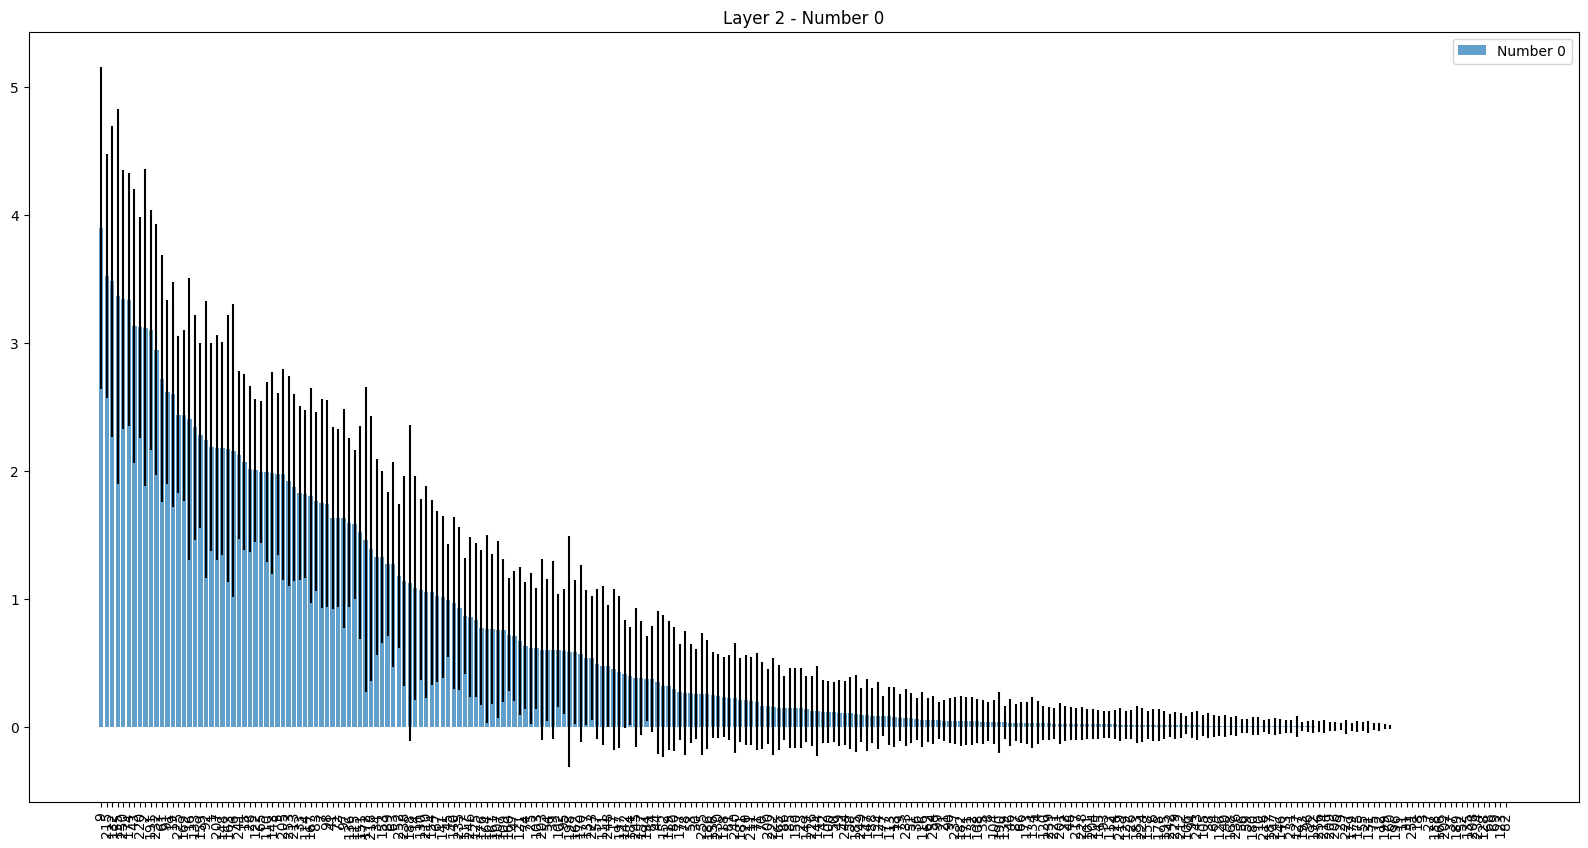

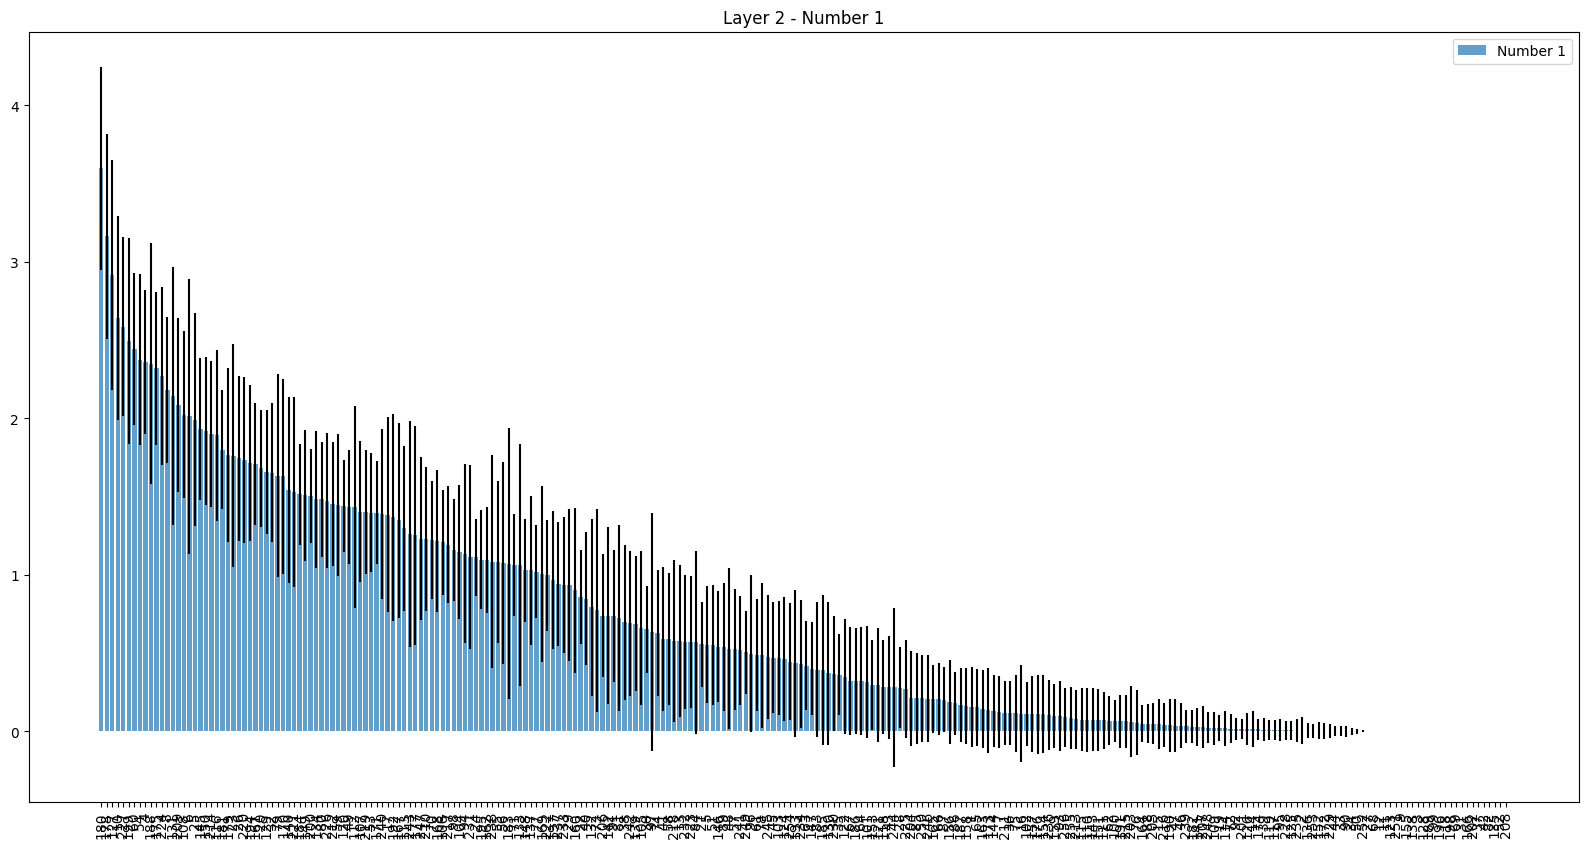

In [43]:
numbers = [0,1]
plot_mean_and_std_bar_per_number(df_layer2, 'Layer 2', numbers)

## GPT-2

In [10]:
# Cargar el archivo pickle proporcionado
file_path = os.path.join('activations', 'gpt2.pickle')

# Leer el contenido del archivo
with open(file_path, 'rb') as file:
    activations = pickle.load(file)

In [61]:
# Diccionario para almacenar los resultados
results = {}

# Iterar a través de las capas y almacenar los resultados en el diccionario
for i in range(activations.shape[0]):  # Asumiendo que activations.shape[0] es el número de capas
    low_neurons, W, H = get_low_activations_neuron_per_layer(activations, i, threshold=0.3, n_components=5)
    print(f'Layer {i}: {len(low_neurons)} low contribution neurons')
    results[f'low_contribution_neurons_layer_{i}'] = low_neurons
    results[f'w_layer_{i}'] = W
    results[f'h_layer_{i}'] = H

Layer 0: 973 low contribution neurons
Layer 1: 1453 low contribution neurons
Layer 2: 848 low contribution neurons
Layer 3: 1176 low contribution neurons
Layer 4: 1363 low contribution neurons
Layer 5: 882 low contribution neurons
Layer 6: 1005 low contribution neurons
Layer 7: 709 low contribution neurons
Layer 8: 1390 low contribution neurons
Layer 9: 1031 low contribution neurons
Layer 10: 793 low contribution neurons
Layer 11: 1198 low contribution neurons


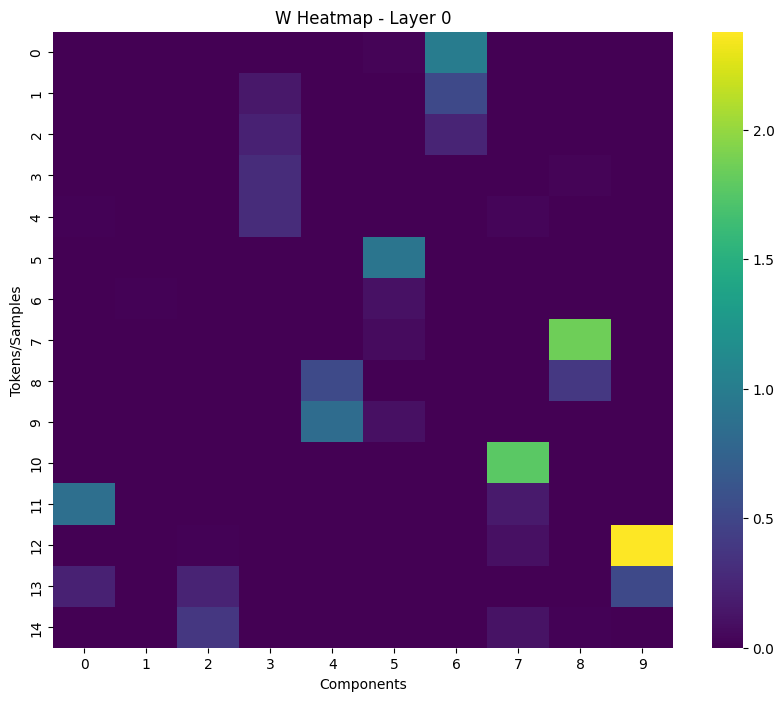

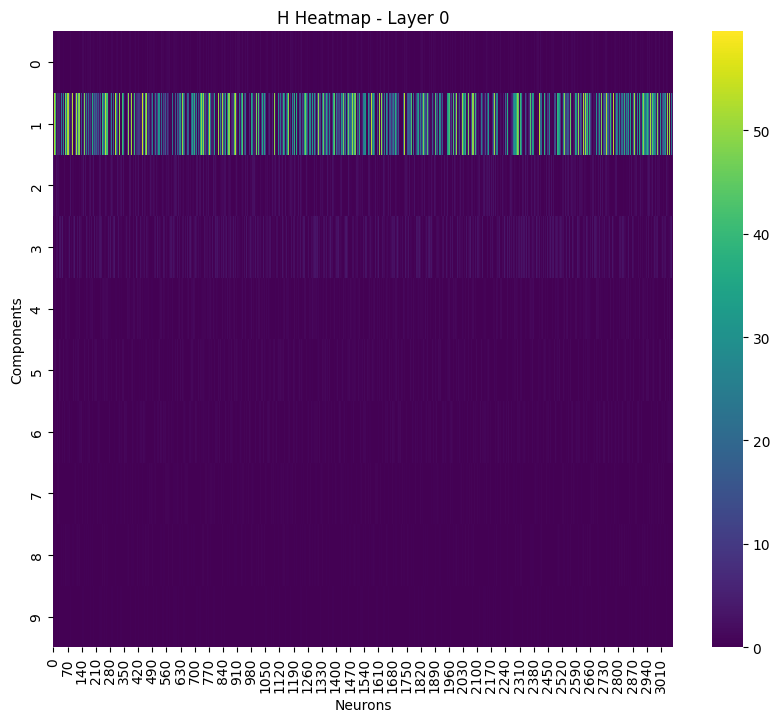

Low contribution neurons in layer 0: 113


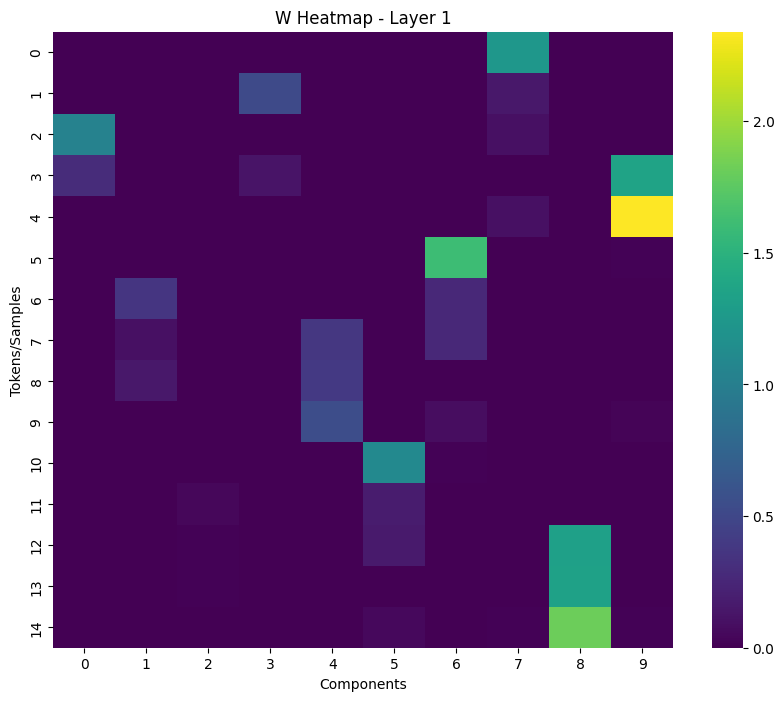

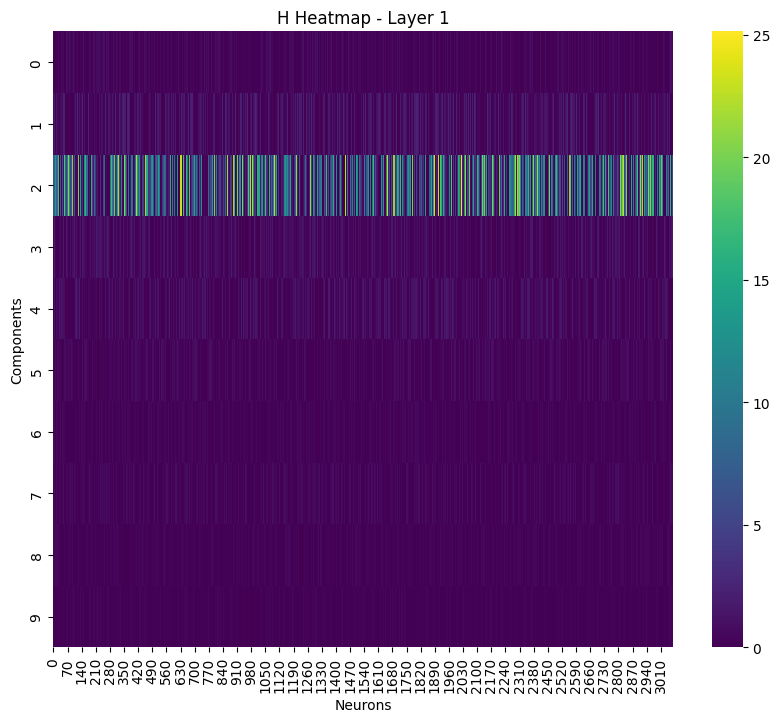

Low contribution neurons in layer 1: 171


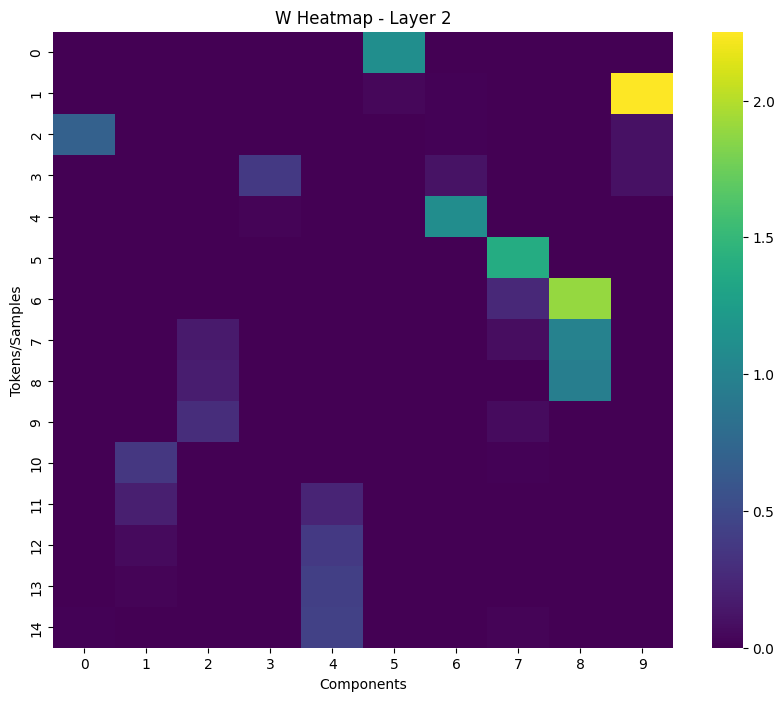

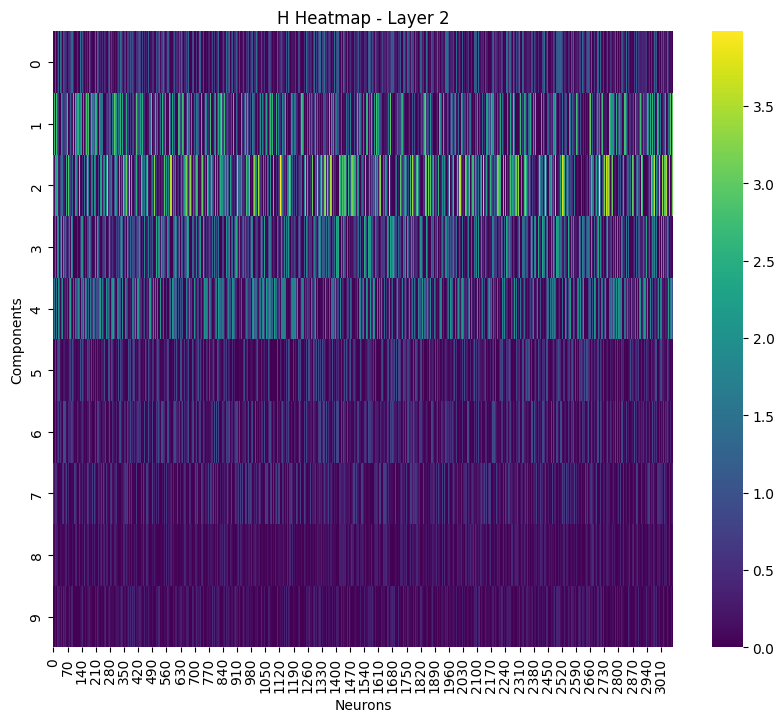

Low contribution neurons in layer 2: 173


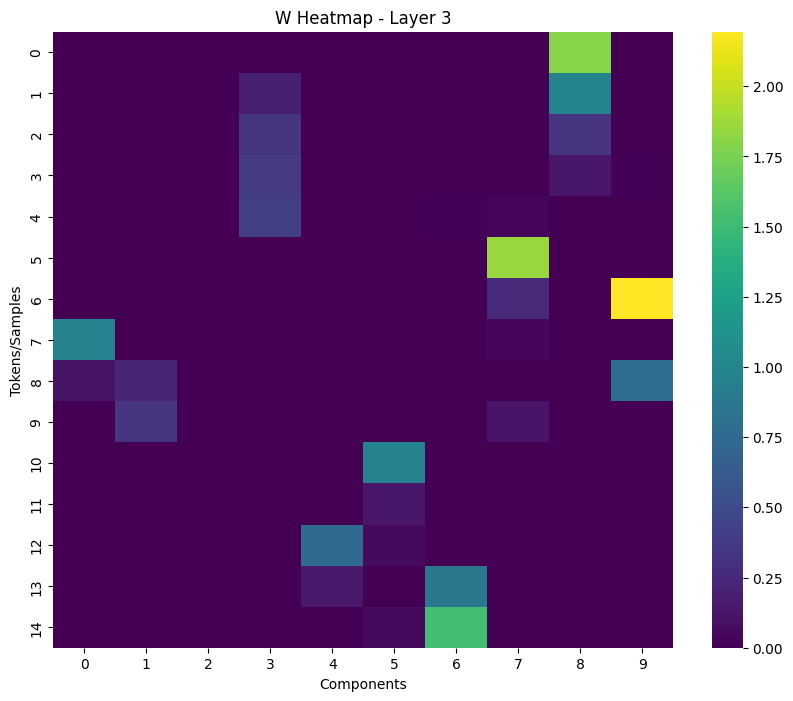

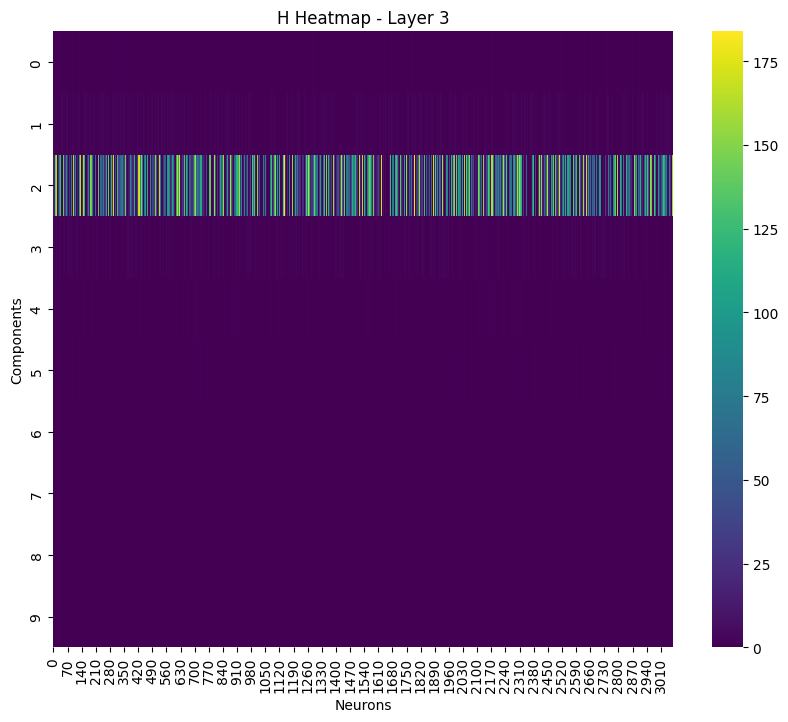

Low contribution neurons in layer 3: 130


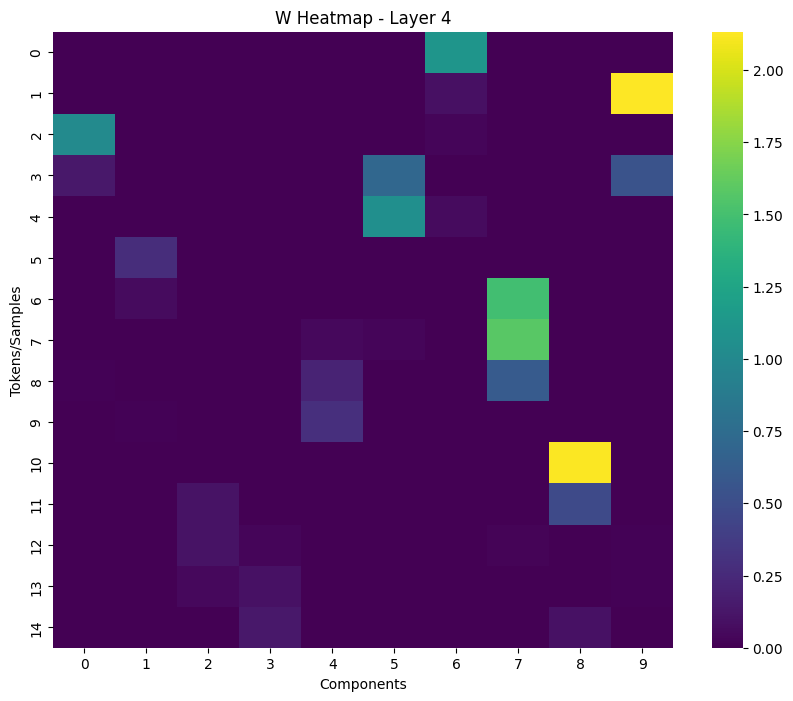

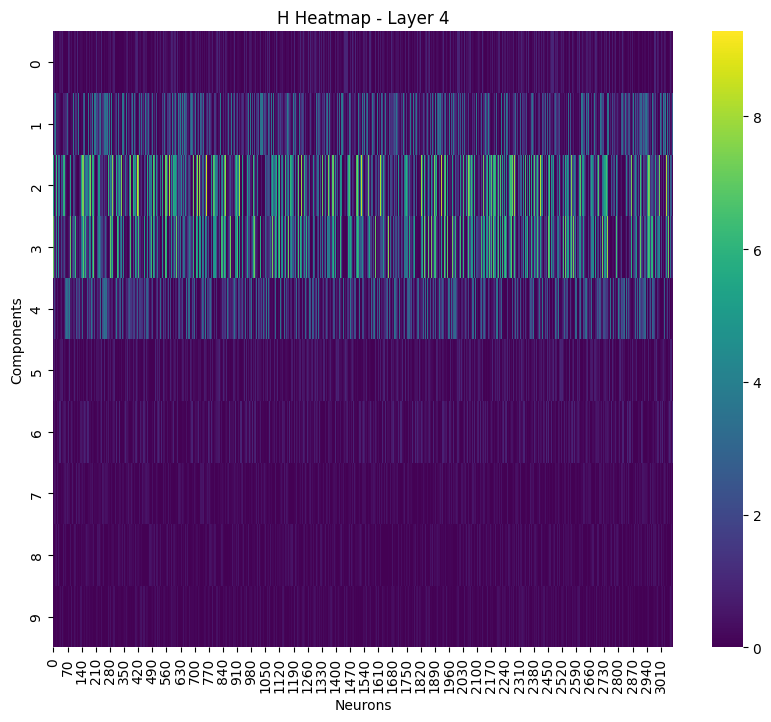

Low contribution neurons in layer 4: 164


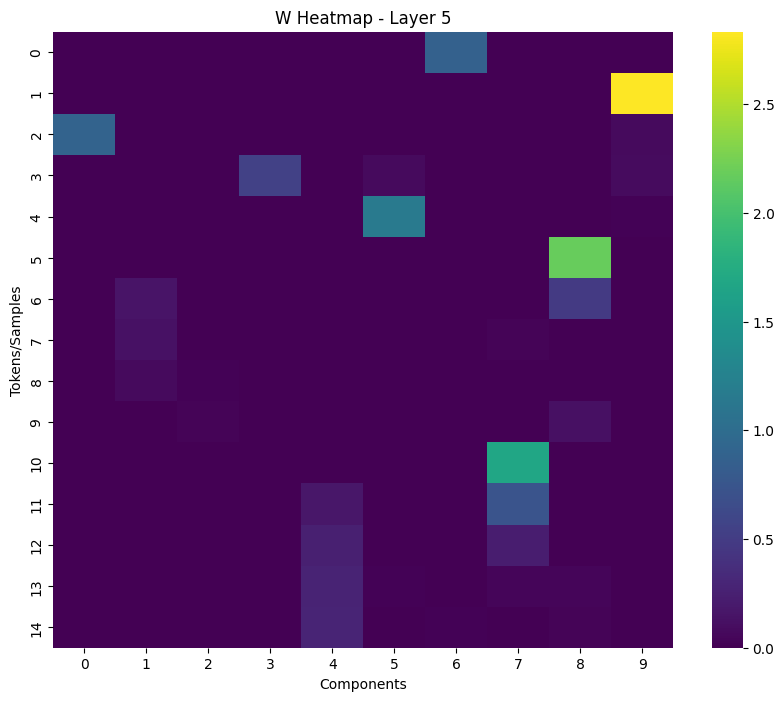

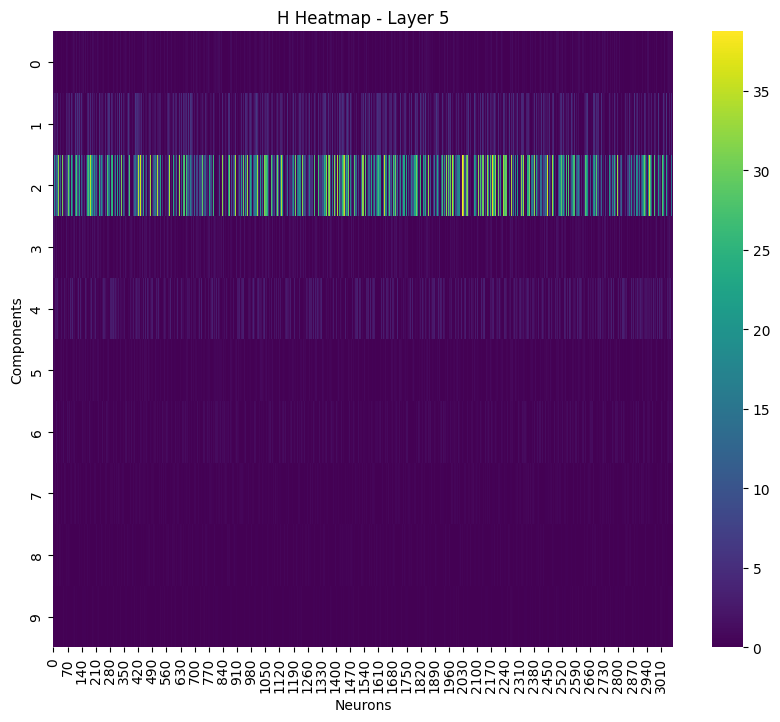

Low contribution neurons in layer 5: 87


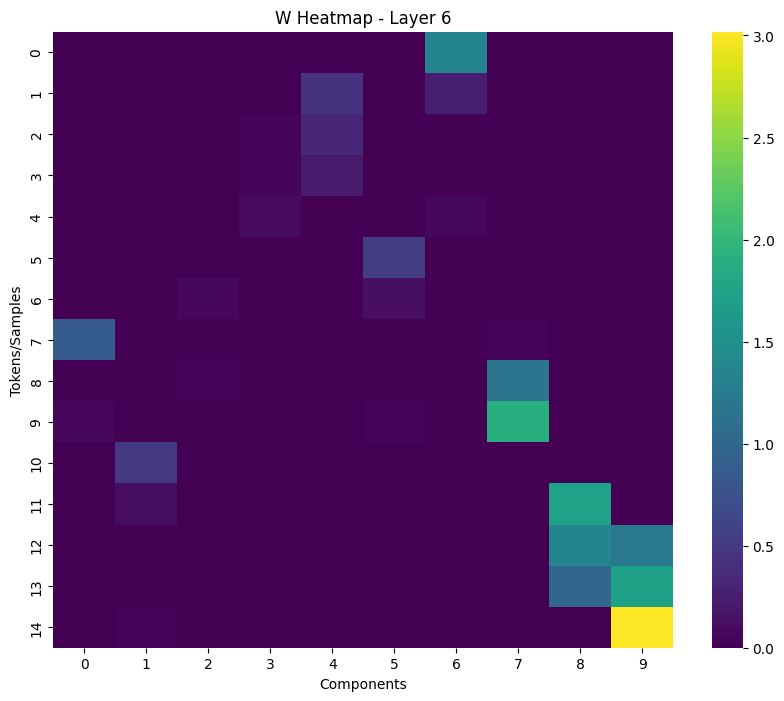

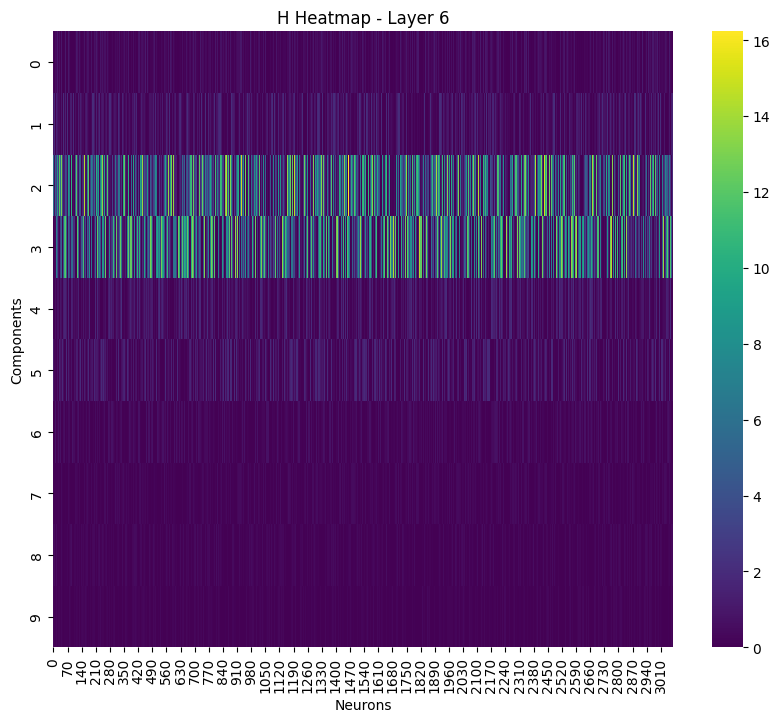

Low contribution neurons in layer 6: 139


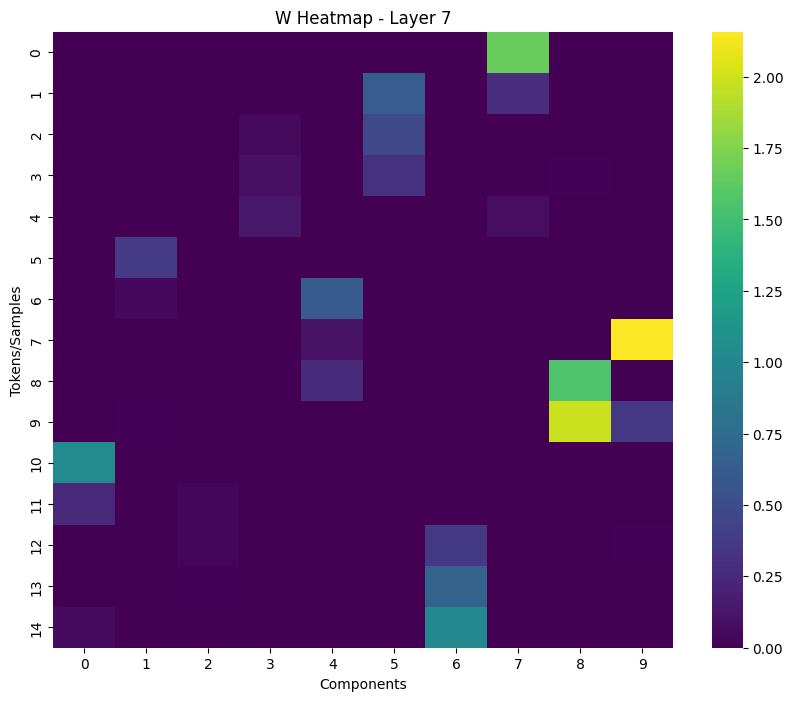

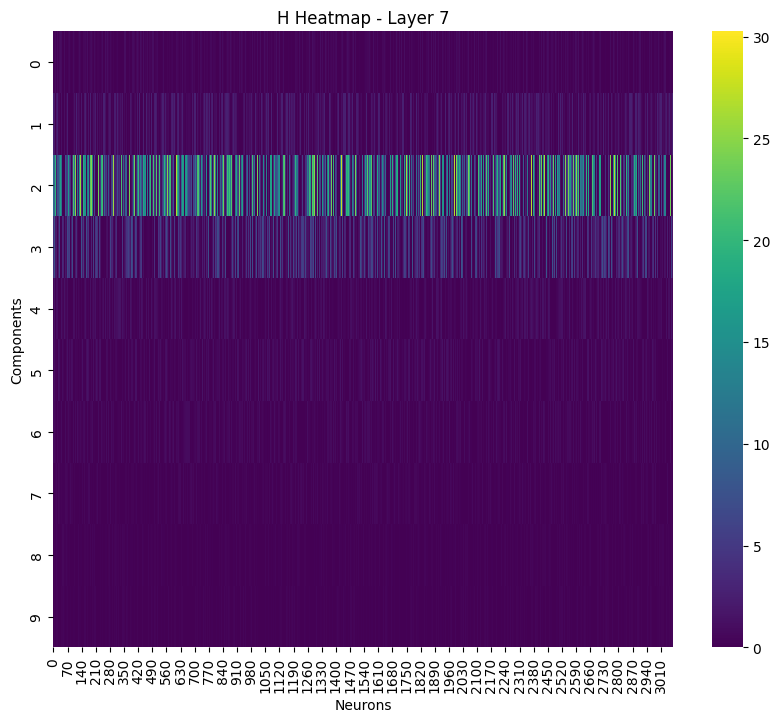

Low contribution neurons in layer 7: 48


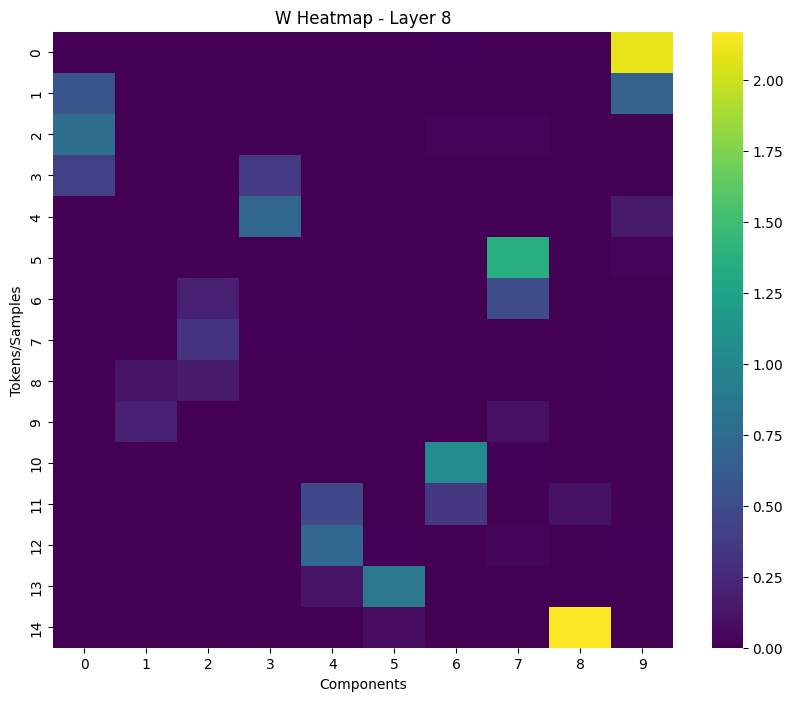

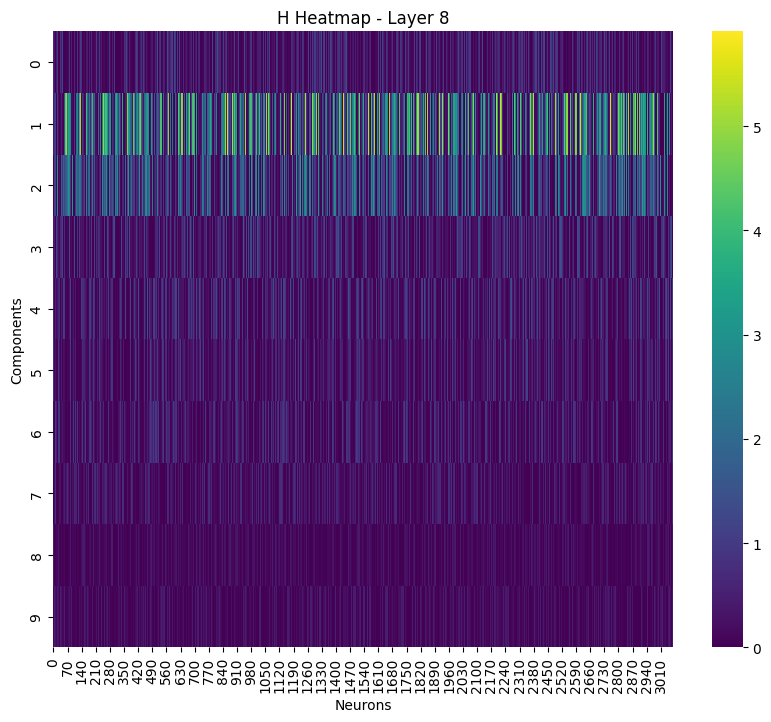

Low contribution neurons in layer 8: 527


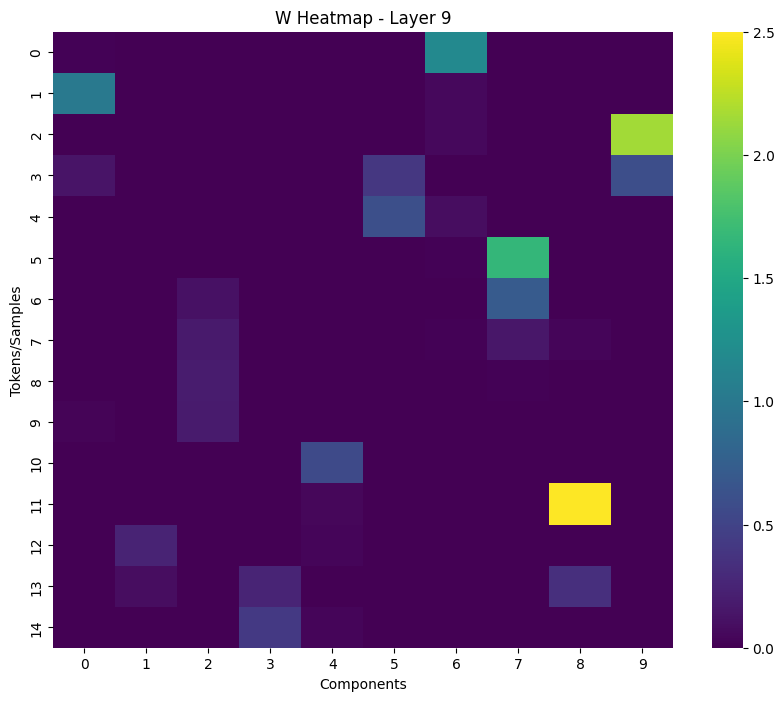

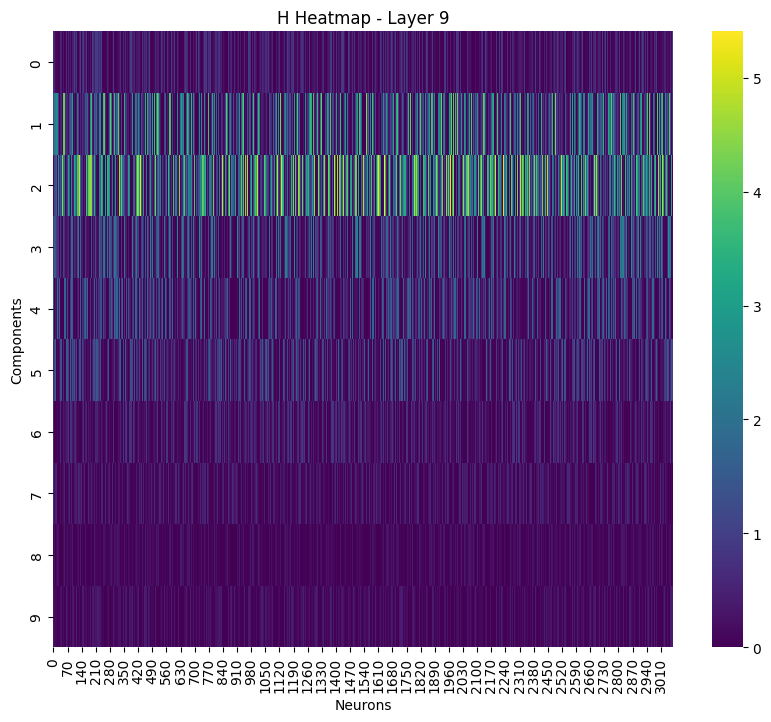

Low contribution neurons in layer 9: 177


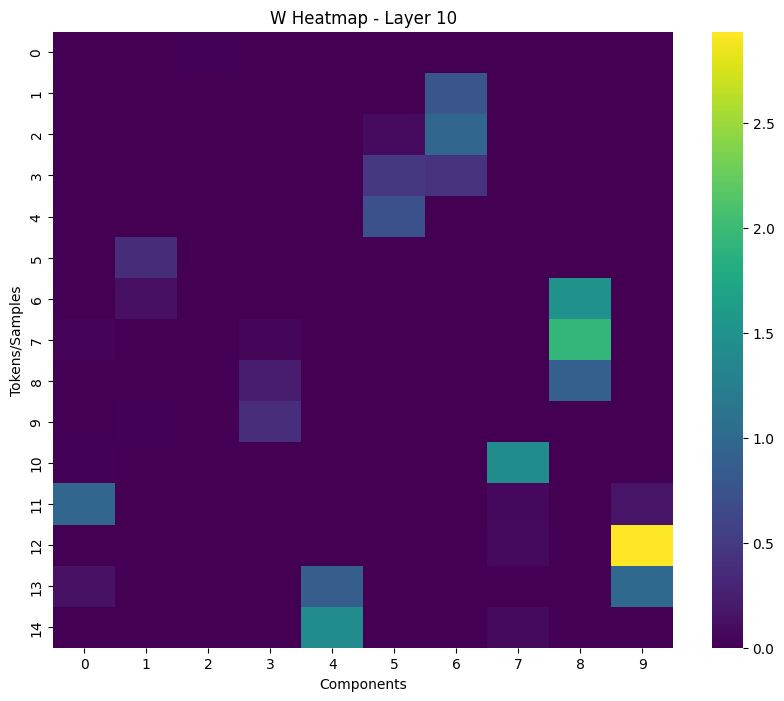

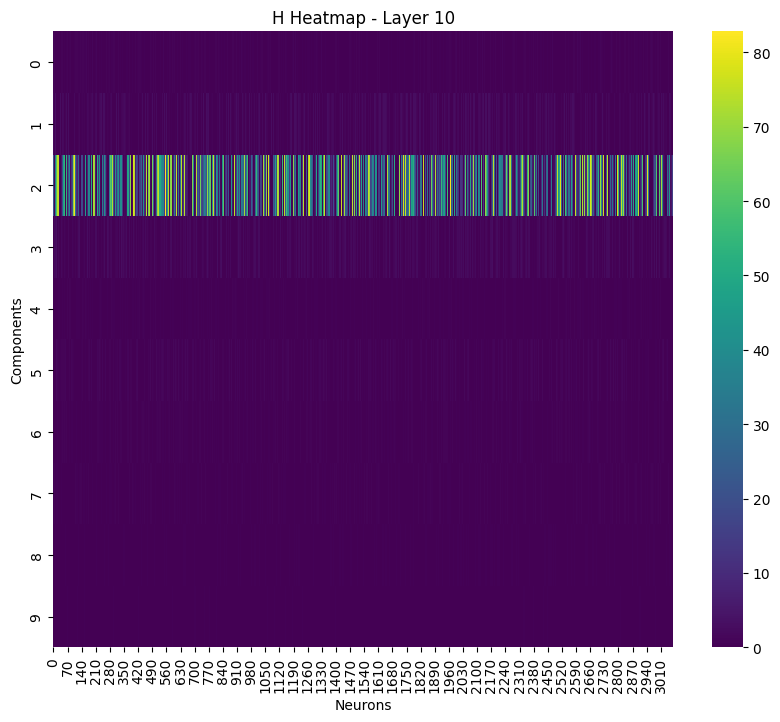

Low contribution neurons in layer 10: 91


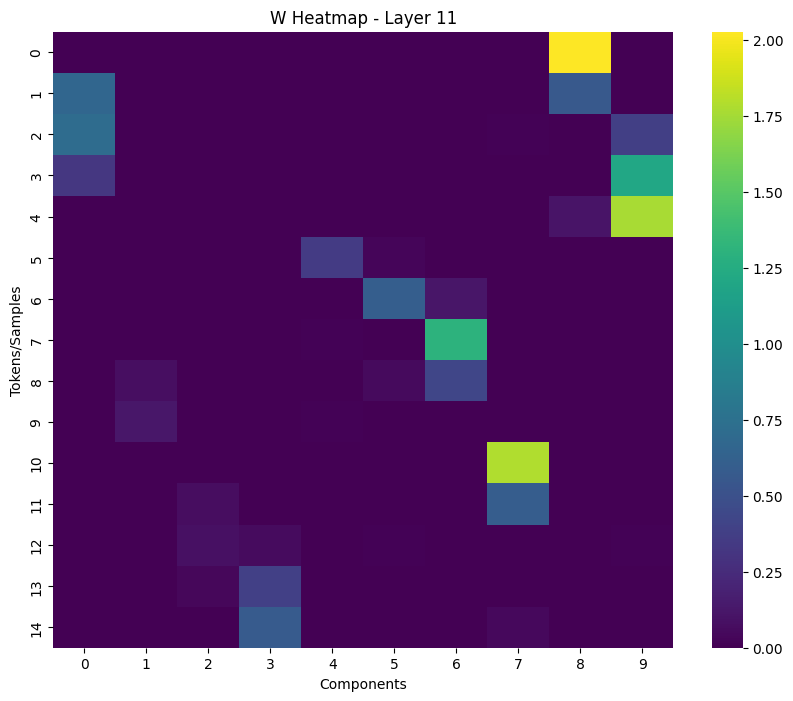

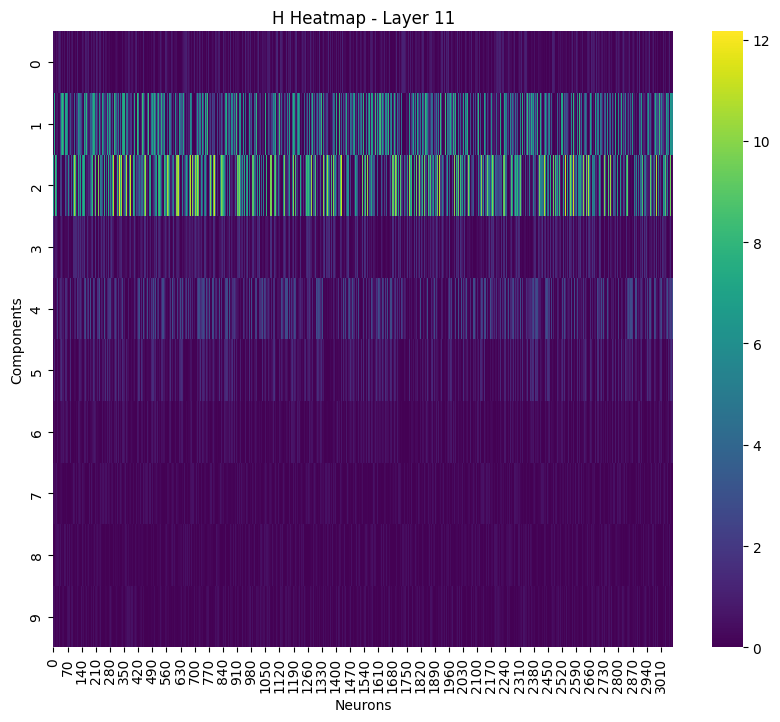

Low contribution neurons in layer 11: 171


In [54]:
for layer in range(activations.shape[0]):
    plot_w_and_h_heatmaps(results[f'w_layer_{layer}'], results[f'h_layer_{layer}'], layer)

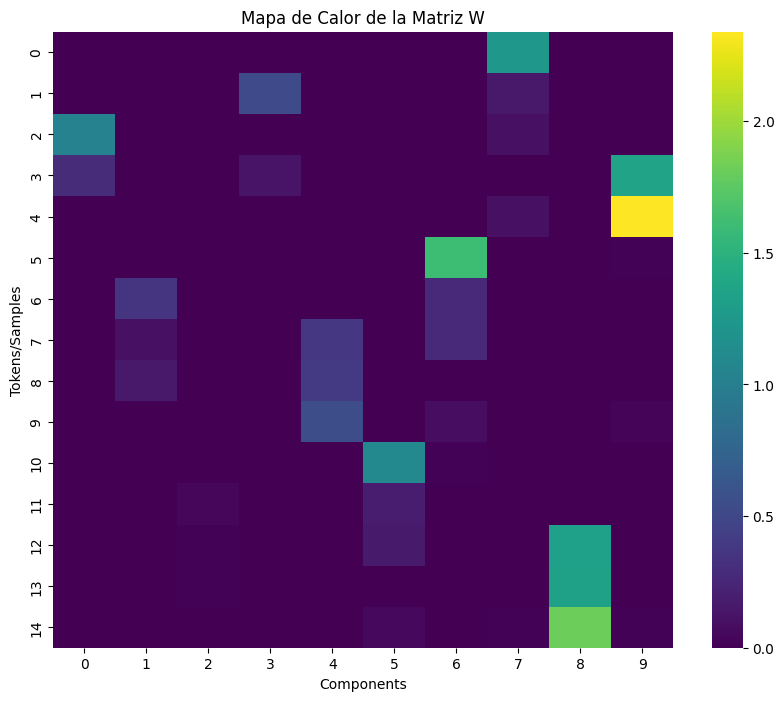

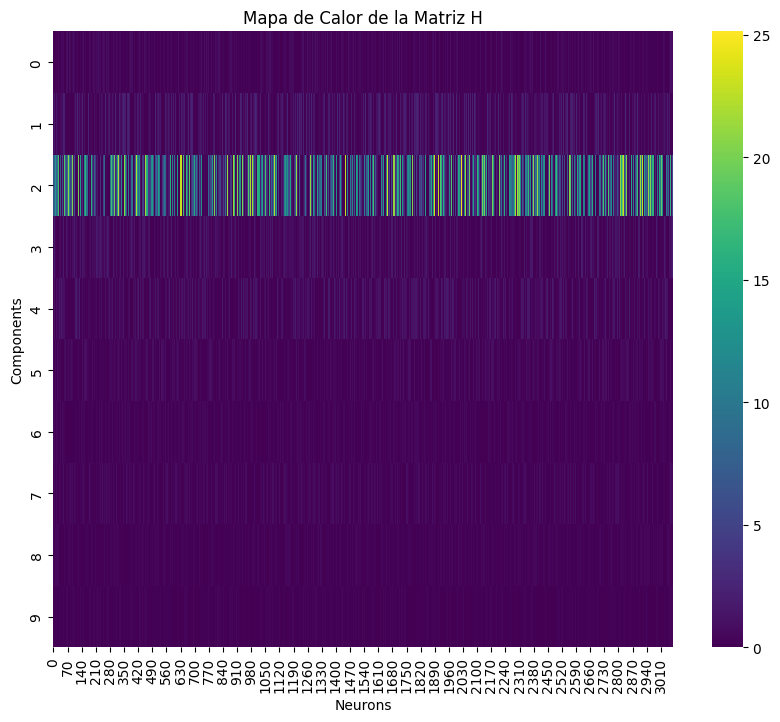

In [50]:
plot_w_and_h_heatmaps(results['w_layer_1'], results['h_layer_1'])

## MNIST NMF pruning

### Training

In [102]:
LEARING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
FOLDER_CHEKPOINTS = 'checkpoints'
FOLDER_ACTIVATIONS = 'activations'
print(f'Using {DEVICE}')

SEED = 2024
pl.seed_everything(SEED)

Seed set to 2024


Using cuda


2024

In [103]:
def load_data(batch_size=BATCH_SIZE, num_workers=4):
    # Transformaciones para los datos
    transform = transforms.ToTensor()

    # Carga de datos de entrenamiento
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    
    # División entre entrenamiento y validación
    train_size = int(0.8 * len(mnist_train))
    val_size = len(mnist_train) - train_size
    mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

    # DataLoader para entrenamiento y validación
    train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True, persistent_workers=True)
    val_loader = DataLoader(mnist_val, batch_size=batch_size, num_workers=num_workers, shuffle=False, persistent_workers=True)

    # Carga de datos de test
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers, persistent_workers=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data()

In [104]:
class MLP(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        """
        Multi-Layer Perceptron model for classification.

        Args:
            num_classes (int): Number of classes for classification. Default is 10.
            lr (float): Learning rate for the optimizer. Default is 1e-3.
        """
        super(MLP, self).__init__()
        self.lr = lr
        self.num_classes = num_classes
        
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)

        # metrics
        self.train_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.val_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.precision = torchmetrics.Precision(num_classes=self.num_classes, average='macro', task='multiclass')
        self.recall = torchmetrics.Recall(num_classes=self.num_classes, average='macro', task='multiclass')
        self.f1 = torchmetrics.F1Score(num_classes=self.num_classes, average='macro', task='multiclass')
        
    def forward(self, x, return_activations=False):
        x = x.view(x.size(0), -1)
        x = F.relu(self.layer_1(x))
        x_layer2 = F.relu(self.layer_2(x))
        x = self.layer_3(x_layer2)
        
        if return_activations:
            return x, x_layer2.cpu().detach().numpy()
        
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_acc(y_hat, y)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.val_acc(y_hat, y)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.test_acc(y_hat, y)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.precision(y_hat, y)
        self.log('precision', self.precision, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.recall(y_hat, y)
        self.log('recall', self.recall, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.f1(y_hat, y)
        self.log('f1', self.f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [105]:
trainer = pl.Trainer(max_epochs=EPOCHS)
model = MLP()
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | layer_1   | Linear              | 100 K 
1 | layer_2   | Linear              | 33.0 K
2 | layer_3   | Linear              | 2.6 K 
3 | train_acc | MulticlassAccuracy  | 0     
4 | val_acc   | MulticlassAccuracy  | 0     
5 | test_acc  | MulticlassAccuracy  | 0     
6 | precision | MulticlassPrecision | 0     
7 | recall    | MulticlassRecall    | 0     
8 | f1        | MulticlassF1Score   | 0     
--------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 750/750 [00:07<00:00, 98.31it/s, v_num=4, train_loss_step=0.194, val_loss=0.168, val_acc=0.950, train_loss_epoch=0.331, train_acc=0.905]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 750/750 [00:07<00:00, 98.01it/s, v_num=4, train_loss_step=0.194, val_loss=0.168, val_acc=0.950, train_loss_epoch=0.331, train_acc=0.905]


In [106]:
# test
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 66.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.9510743618011475
        precision           0.9512325525283813
         recall             0.9510959982872009
        test_acc            0.9516000151634216
        test_loss           0.1562192291021347
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1562192291021347,
  'test_acc': 0.9516000151634216,
  'precision': 0.9512325525283813,
  'recall': 0.9510959982872009,
  'f1': 0.9510743618011475}]

In [107]:
# save model
torch.save(model.state_dict(), os.path.join(FOLDER_CHEKPOINTS, 'mlp_model_mnist.pth'))

### recolect activations 0 -1

In [152]:
# load model
model = MLP()

# load state dict
model.load_state_dict(torch.load(os.path.join(FOLDER_CHEKPOINTS, 'mlp_model_mnist.pth')))

<All keys matched successfully>

In [153]:
classes_to_include = [0,2,4,6,8]
train_loader_filtered, val_loader_filtered, test_loader_filtered = load_data_filtered(BATCH_SIZE, classes_to_include, num_workers=0)


In [154]:
mnist_model_trainer = pl.Trainer(max_epochs=5)
# test model
mnist_model_trainer.test(model, test_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 77/77 [00:01<00:00, 45.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.4824814796447754
        precision           0.48892906308174133
         recall             0.4763937294483185
        test_acc            0.9526999592781067
        test_loss           0.15905052423477173
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.15905052423477173,
  'test_acc': 0.9526999592781067,
  'precision': 0.48892906308174133,
  'recall': 0.4763937294483185,
  'f1': 0.4824814796447754}]

In [155]:
# recolectar las activaciones de la capa 2
activations = []
for batch in tqdm(test_loader_filtered):
    x, y = batch
    _, layer2_activations = model(x, return_activations=True)
    activations.append(layer2_activations)

activations = np.concatenate(activations, axis=0)
activations.shape

100%|██████████| 77/77 [00:00<00:00, 206.98it/s]


(4926, 256)

In [191]:
def get_low_activations_neuron_per_layer_minst(activations: np.array, threshold: float = 0.3, n_components: int = 10) -> tuple:
    
    scaler = MinMaxScaler()
    normalized_activations = scaler.fit_transform(activations.reshape(-1, activations.shape[-1])).reshape(activations.shape)

    nmf = NMF(n_components=n_components)
    w = nmf.fit_transform(normalized_activations)  # Aplana las activaciones para NMF
    h = nmf.components_
    
    low_contribution_neurons = np.where(h.mean(axis=0) < threshold)[0]

    return low_contribution_neurons, w, h

In [194]:
low_neurons, W, H = get_low_activations_neuron_per_layer_minst(activations, threshold=0.5, n_components=15)

In [195]:
print(f'Layer 2: {len(low_neurons)} low contribution neurons')

Layer 2: 87 low contribution neurons


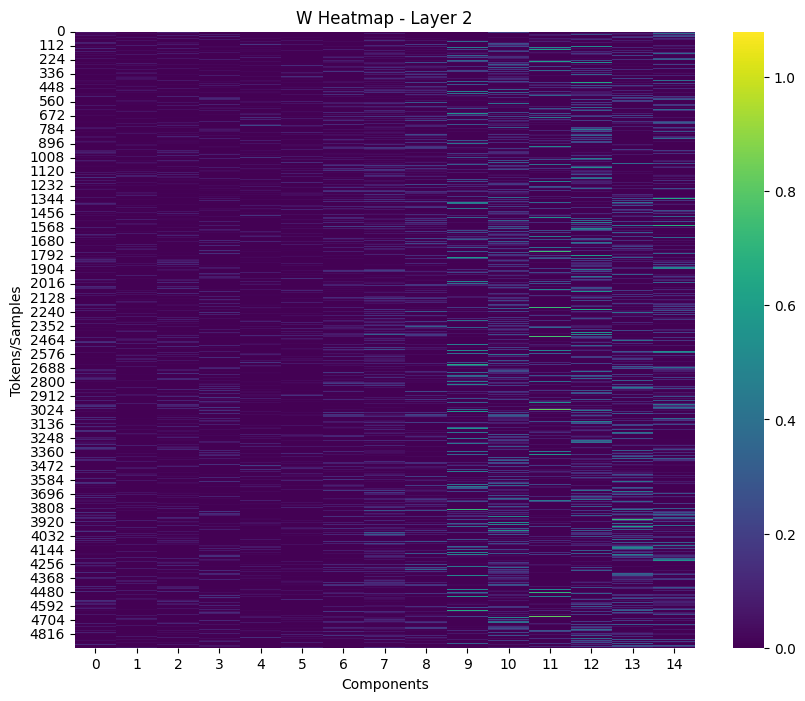

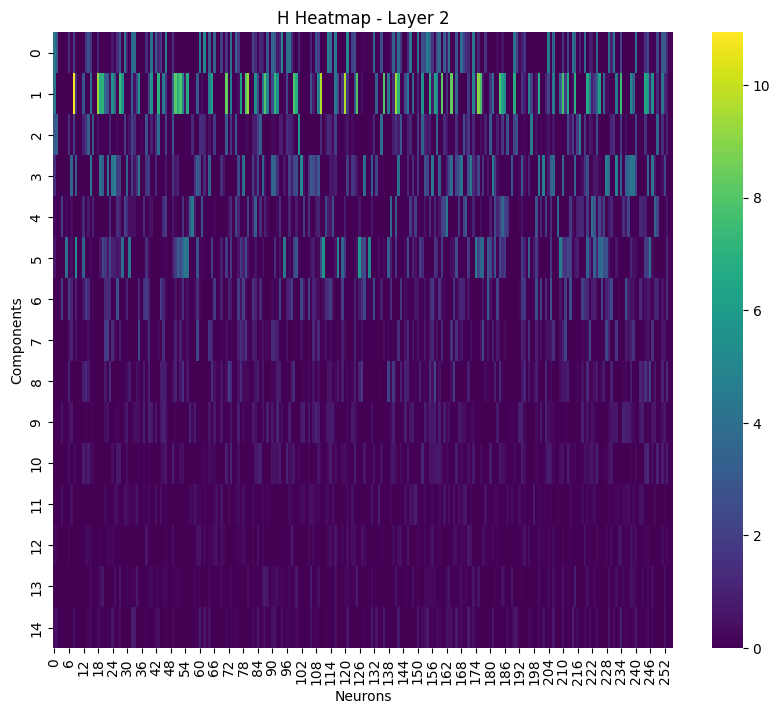

In [196]:
plot_w_and_h_heatmaps(W, H, 2)

In [197]:
import copy


def remove_neurons_from_layer(layer, neurons_to_remove):
    new_weights = torch.cat([layer.weight.data[i:i+1] for i in range(layer.weight.data.size(0)) if i not in neurons_to_remove])
    new_bias = torch.cat([layer.bias.data[i:i+1] for i in range(layer.bias.data.size(0)) if i not in neurons_to_remove])
    return nn.Linear(new_weights.size(1), new_weights.size(0)), new_weights, new_bias

def adjust_next_layer(layer, neurons_to_remove_from_previous_layer):
    new_weights = torch.cat([layer.weight.data[:, i:i+1] for i in range(layer.weight.data.size(1)) if i not in neurons_to_remove_from_previous_layer], 1)
    return nn.Linear(new_weights.size(1), new_weights.size(0)), new_weights

def prune(model: nn.Module, mask: list) -> nn.Module:
    model_copy = copy.deepcopy(model)
    layer_name = "layer_2"
    next_layer_name = "layer_3"


    # Aplicar la poda y ajustar las capas
    # Asumimos que las capas están nombradas de forma estándar (layer_1, layer_2, etc.)
    current_layer = getattr(model_copy, layer_name)

    # Eliminar neuronas de la capa actual
    new_layer, new_weights, new_biases = remove_neurons_from_layer(current_layer, mask)
    setattr(model_copy, layer_name, new_layer)
    model_copy._modules[layer_name].weight.data = new_weights
    model_copy._modules[layer_name].bias.data = new_biases

    # Ajustar la siguiente capa si existe
    if hasattr(model_copy, next_layer_name):
        next_layer = getattr(model_copy, next_layer_name)
        new_next_layer, new_next_weights = adjust_next_layer(next_layer, mask)
        setattr(model_copy, next_layer_name, new_next_layer)
        model_copy._modules[next_layer_name].weight.data = new_next_weights

    return model_copy

In [198]:
model_copy = copy.deepcopy(model)
model_pruning = prune(model_copy, low_neurons)

In [199]:
print(model)

MLP(
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
)


In [200]:
print(model_pruning)

MLP(
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=169, bias=True)
  (layer_3): Linear(in_features=169, out_features=10, bias=True)
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
)


In [201]:
# test model
mnist_model_trainer.test(model_pruning, test_loader_filtered)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 77/77 [00:01<00:00, 46.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           f1               0.5221872329711914
        precision           0.5284942388534546
         recall             0.5176076292991638
        test_acc            0.9305724501609802
        test_loss           0.2221183329820633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2221183329820633,
  'test_acc': 0.9305724501609802,
  'precision': 0.5284942388534546,
  'recall': 0.5176076292991638,
  'f1': 0.5221872329711914}]

In [202]:
# train
mnist_model_trainer = pl.Trainer(max_epochs=5)
mnist_model_trainer.fit(model_pruning, train_loader_filtered, val_loader_filtered)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | layer_1   | Linear              | 100 K 
1 | layer_2   | Linear              | 21.8 K
2 | layer_3   | Linear              | 1.7 K 
3 | train_acc | MulticlassAccuracy  | 0     
4 | val_acc   | MulticlassAccuracy  | 0     
5 | test_acc  | MulticlassAccuracy  | 0     
6 | precision | MulticlassPrecision | 0     
7 | recall    | MulticlassRecall    | 0     
8 | f1        | MulticlassF1Score   | 0     
--------------------------------------------------
123 K     Trainable params
0         Non-trainable params
123 K     Total params
0.496     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 369/369 [00:05<00:00, 66.91it/s, v_num=9, train_loss_step=0.00501, val_loss=0.0546, val_acc=0.985, train_loss_epoch=0.0122, train_acc=0.996] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 369/369 [00:05<00:00, 66.81it/s, v_num=9, train_loss_step=0.00501, val_loss=0.0546, val_acc=0.985, train_loss_epoch=0.0122, train_acc=0.996]


## Experiment

In [238]:
# load model
model = MLP()

# load state dict
model.load_state_dict(torch.load(os.path.join(FOLDER_CHEKPOINTS, 'mlp_model_mnist.pth')))

<All keys matched successfully>

In [239]:
classes_to_include = [0,1]
train_loader_filtered, val_loader_filtered, test_loader_filtered = load_data_filtered(BATCH_SIZE, classes_to_include, num_workers=0)

In [242]:
accuracis = []
neurons_deleted = []
n_components = 10

for threshold in np.arange(0.1, 1, 0.1):
    low_neurons, W, H = get_low_activations_neuron_per_layer_minst(activations, threshold=threshold, n_components=n_components)
    model_copy = copy.deepcopy(model)
    model_pruning = prune(model_copy, low_neurons)
    test_results = mnist_model_trainer.test(model_pruning, test_loader_filtered, verbose=False)
    accuracis.append(test_results[0]['test_acc']*100)
    # calculated percentage of neurons deleted
    percentage = (len(low_neurons)/model.layer_2.weight.data.size(0))*100
    neurons_deleted.append(percentage)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 39.04it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 60.52it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 55.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 60.39it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 51.73it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 59.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 61.79it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 55.76it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 58.10it/s]


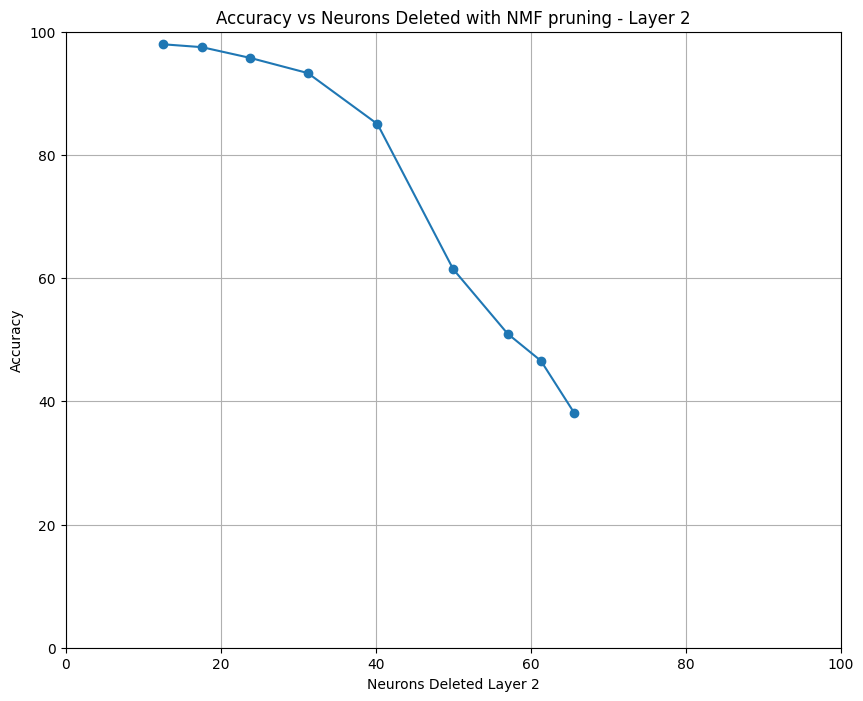

In [245]:
# plot results
plt.figure(figsize=(10, 8))
plt.plot(neurons_deleted, accuracis, 'o-')
plt.title('Accuracy vs Neurons Deleted with NMF pruning - Layer 2')
plt.xlabel('Neurons Deleted Layer 2')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.axvline(x=128, color='r', linestyle='--')
# grid
plt.grid(True)
plt.show()